# Import standard libraries

In [53]:
import os
import random
import urllib.request
from urllib.error import HTTPError

### plotting

In [54]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### pytorch

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pytorch_lightning as pl
import torchvision

### calbacks and dataset

In [56]:
from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import MNIST

set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  


### path for saving model and downloadind data

In [57]:
DATASET_PATH = os.environ.get("PATH_DATASETS", "data")
#We use the saved model in this implementation
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/NNProject")

### setting seed and Ensure that all operations are deterministic on GPU

In [58]:
pl.seed_everything(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

### download pretrained model that saved before

In [59]:
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"

pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the files manually,"
            )

### Data preparation

In [60]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

test_data = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_dataloader = data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

### We implement the basic model which is CNN and use switch relu instead of ReLU

In [61]:
class Model(nn.Module):
    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        hidden_features1 = hidden_features // 2
        hidden_features2 = hidden_features
        hidden_features3 = hidden_features * 2

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, hidden_features1, kernel_size=5, stride=2, padding=4), 
            nn.SiLU(),
            nn.Conv2d(hidden_features1, hidden_features2, kernel_size=3, stride=2, padding=1), 
            nn.SiLU(),
            nn.Conv2d(hidden_features2, hidden_features3, kernel_size=3, stride=2, padding=1),  
            nn.SiLU(),
            nn.Conv2d(hidden_features3, hidden_features3, kernel_size=3, stride=2, padding=1),  
            nn.SiLU(),
            nn.Flatten(),
            nn.Linear(hidden_features3 * 4, hidden_features3),
            nn.SiLU(),
            nn.Linear(hidden_features3, out_dim),
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

### MCMC Sampling

In [62]:
class Sampler:
    # max_len: Maximum number of data points to keep in the buffer
    def __init__(self, model, img_shape, sample_size, max_len=8192):
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,) + img_shape) * 2 - 1) for _ in range(self.sample_size)]

        
    def sample_new_exmps(self, steps=60, step_size=10):
        # new batch of "fake" images
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[: self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True


        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        imgs_per_step = []

        for _ in range(steps):
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03)  
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())


        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

# Our Final Model based on Deep Energy_Based

In [63]:
class DeepEnergyModel(pl.LightningModule):
    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()
        self.cnn = Model(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97)  # Exponential decay over epochs
        return [optimizer], [scheduler]

    
    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)
        
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        # Logging
        self.log("loss", loss)
        self.log("loss_regularization", reg_loss)
        self.log("loss_contrastive_divergence", cdiv_loss)
        self.log("metrics_avg_real", real_out.mean())
        self.log("metrics_avg_fake", fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log("val_contrastive_divergence", cdiv)
        self.log("val_fake_out", fake_out.mean())
        self.log("val_real_out", real_out.mean())

## start training

In [64]:
def train_model(**kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "MNIST"),
        gpus=1 if str(device).startswith("cuda") else 0,
        max_epochs=60,
        gradient_clip_val=0.1
    )
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    return model

In [65]:
model = train_model(img_shape=(1, 28, 28), batch_size=train_dataloader.batch_size, lr=1e-4, beta1=0.0)

Found pretrained model, loading...


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:442: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"


### generate images

#### first we creat GenerateCallback, that is used for adding image generations to the model during training.

In [89]:
class GenerateCallback(pl.Callback):
    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size  
        self.vis_steps = vis_steps  
        self.num_steps = num_steps  
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            imgs_per_step = self.generate_imgs(pl_module)
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size - 1 :: step_size, i]
                grid = torchvision.utils.make_grid(
                    imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1, 1)
                )
                trainer.logger.experiment.add_image("generation_%i" % i, grid, global_step=trainer.current_epoch)

    def generate_imgs(self, pl_module):
        pl_module.eval()
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        start_imgs = start_imgs * 2 - 1
        imgs_per_step = Sampler.generate_samples(
            pl_module.cnn, start_imgs, steps=self.num_steps, step_size=10, return_img_per_step=True
        )
        pl_module.train()
        return imgs_per_step

In [90]:
callback = GenerateCallback(batch_size=2, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(model)

In [91]:
def generate_images(imgs_per_step, callback):
    
    for i in range(imgs_per_step.shape[1]):
        step_size = callback.num_steps // callback.vis_steps
        imgs_to_plot = imgs_per_step[step_size - 1 :: step_size, i]
        imgs_to_plot = torch.cat([imgs_per_step[0:1, i], imgs_to_plot], dim=0)
        grid = torchvision.utils.make_grid(
            imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1, 1), pad_value=0.5, padding=2
        )
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid)
        plt.xlabel("Generation iteration")
        plt.xticks(
            [(imgs_per_step.shape[-1] + 2) * (0.5 + j) for j in range(callback.vis_steps + 1)],
            labels=[1] + list(range(step_size, imgs_per_step.shape[0] + 1, step_size)),
        )
        plt.yticks([])
        plt.show()

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


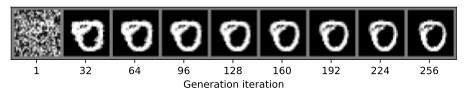

/opt/conda/lib/python3.7/site-packages/torchvision/utils.py:64: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


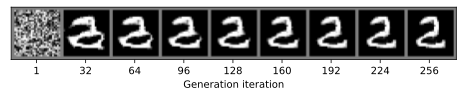

In [92]:
generate_images(imgs_per_step, callback)